In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import json
from os.path import join

import pyvista as pv

import Logger

In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
def renderMesh(camRTs, cfg, mesh, renderer):
    images= []
    with torch.no_grad():
        for iCam in range(cfg.numCams):
            R=camRTs[iCam]['R']
            T=camRTs[iCam]['T']
            image = renderer.renderer(meshes_world=mesh, R=R, T=T).cpu().numpy()
            images.append(image)
    return images

def saveVTK(outFile, verts, smplshExampleMesh):
    smplshExampleMesh.points = verts
    smplshExampleMesh.save(outFile)

def visualize2DSilhouetteResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                imgAlpha = images[iCam][0,...,3]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam]) * 0.5
#                     fgMask = np.logical_not(np.where())
#                     for iChannel in range(3):
                    img[..., 0] = img[..., 0] + imgAlpha * 0.5
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [5]:
# outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataPose'
outFolder = r'F:\WorkingCopy2\2020_07_15_NewInitialFitting\InitialSilhouetteFitting'

In [6]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder = r'F:\WorkingCopy2\2020_06_04_SilhouetteExtraction\3052\Silhouette'

# modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Models\03052.obj'
# modelFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSHFit\LadaOldSuit_WithOPKeypoints_DenseSparsePts\03052.obj'
modelFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\SmplshFittedToSparse.obj'

smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

KeypointsFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\KepPoints\00352.obj'
# initialFittingParamFile = r'F:\WorkingCopy2\2020_05_21_AC_FramesDataToFitTo\FitToSparseCloud\FittingParams\03052.npz'
smplshRegressorMatFile = r'C:\Code\MyRepo\ChbCapture\08_CNNs\Openpose\SMPLSHAlignToAdamWithHeadNoFemurHead\smplshRegressorNoFlatten.npy'

compressedStorage = False
initialFittingParamPoseFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\OptimizedPoses_ICPTriangle.npy'
initialFittingParamBetasFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\OptimizedBetas_ICPTriangle.npy'
initialFittingParamTranslationFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\OptimizedTranslation_ICPTriangle.npy'


In [7]:
# smplshData = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SmplshModel.npz'
smplshData = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\BuildSmplsh\Output\SmplshModel_m.npz'

smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

pose_size = 3 * 52
beta_size = 10
OPHeadKeypoints = [0, 15, 16, 17, 18]

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)
# The head joint regressor
Keypoints = pv.PolyData(KeypointsFile)

jointConverter = Utility.VertexToOpJointsConverter()

In [8]:

if compressedStorage:
    fitParam = np.load(initialFittingParamFile)
    transInit = fitParam['trans']
    poseInit = fitParam['pose']
    betaInit = fitParam['beta']
else:
    transInit = np.load(initialFittingParamTranslationFile)
    poseInit = np.load(initialFittingParamPoseFile)
    betaInit = np.load(initialFittingParamBetasFile)
    
smplsh = smplsh_torch.SMPLModel(device, smplshData)

pose = torch.tensor(poseInit, dtype=torch.float64, requires_grad = True, device=device)
betas = torch.tensor(betaInit, dtype=torch.float64, requires_grad = True, device=device)
trans = torch.tensor(transInit, dtype=torch.float64, 
                     requires_grad = True, device=device)

# verts = smplsh(betas, pose, trans).type(torch.float32) * 1000

verts, jointsDeformed = smplsh(betas, pose, trans, returnDeformedJoints=True)
verts = verts.type(torch.float32) * 1000
jointsDeformed = jointsDeformed.type(torch.float32) * 1000

smplshMesh = Meshes([verts], [smplsh.faces.to(device)])

In [9]:
# # Validate the head points regressor
# headJoints = smplshRegressorMatHead @ verts.cpu().detach().numpy()
# headJoints - Keypoints.points[OPHeadKeypoints, :]
smplshOpJoints = jointConverter(verts[None, ...], jointsDeformed[None, ...])
headJoints = torch.index_select(smplshOpJoints, 1, torch.tensor(OPHeadKeypoints, dtype=torch.long, device=device))[0,...]
headJoints.detach().cpu().numpy() - Keypoints.points[OPHeadKeypoints, :]

C:\Code\MyRepo\03_capture\BodyTracking\AC_ModelFitting\Utility.py:337: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, dtype=dtype, device=device)


pyvista_ndarray([[ 4.6429443 , -2.444519  , -5.47229   ],
                 [-2.1245117 , 12.29657   ,  2.8979492 ],
                 [ 2.3980408 , -3.6830444 ,  5.1899414 ],
                 [12.575958  , -5.877777  ,  2.1621094 ],
                 [-0.42599487, -5.0627136 ,  2.5048828 ]], dtype=float32)

In [10]:
actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
cams = init_camera_batches(cams_torch, device)

actual_img_shape: (2160, 4000)


In [11]:
# load Images
image_refs_out, crops_out = load_images(imageFolder, cropSize=1080)

In [12]:
crops_out[0].max()

1.0

In [13]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
        s.lpSmootherW = 0.1
        s.normalSmootherW = 0.1

        s.biLaplacian = False
        s.jointRegularizerWeight = 0.000001
        
        s.kpFixingWeight = 1
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [14]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1

# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

# cfg.plotStep = 20
cfg.plotStep = 20

cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
# cfg.learningRate = 1
# cfg.learningRate = 0.002
cfg.learningRate = 0.0001

# cfg.learningRate = 0.01
# cfg.learningRate = 0.2

# cfg.normalShiftLevel = 10
cfg.normalShiftLevel = -3

# cfg.faces_per_pixel = 14
# cfg.faces_per_pixel = 30
# cfg.faces_per_pixel = 15
cfg.faces_per_pixel = 5

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1

# cfg.lpSmootherW = 0.001

cfg.lpSmootherW = 0.0001
# cfg.kpFixingWeight = 0.001
cfg.kpFixingWeight = 0.01

# cfg.normalSmootherW = 0.1
cfg.normalSmootherW = 0.1

renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [15]:
expName = 'PoseFitting_HeadKP__Sig' + str(cfg.sigma) + '_BR' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams' + str(cfg.numCams)+ '_ImS' + str(cfg.imgSize) + '_LR' + str(cfg.learningRate) +'_JR' + str(cfg.jointRegularizerWeight) + '_KPW' + str(cfg.kpFixingWeight)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump({"CfgSynth":cfg.__dict__, "CfgRef":cfgRef.__dict__,}, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_07_15_NewInitialFitting\InitialSilhouetteFitting\PoseFitting_HeadKP__Sig1e-07_BR1e-07_Fpp5_NCams16_ImS1080_LR0.0001_JR1e-06_KPW0.01


In [16]:
camRTs = []
for iCam in range(cfg.numCams):
    R, T = look_at_view_transform(2.7, 0, 360 * iCam / cfg.numCams, device=device) 
    camRTs.append({'R':R, 'T':T})

<IPython.core.display.Javascript object>


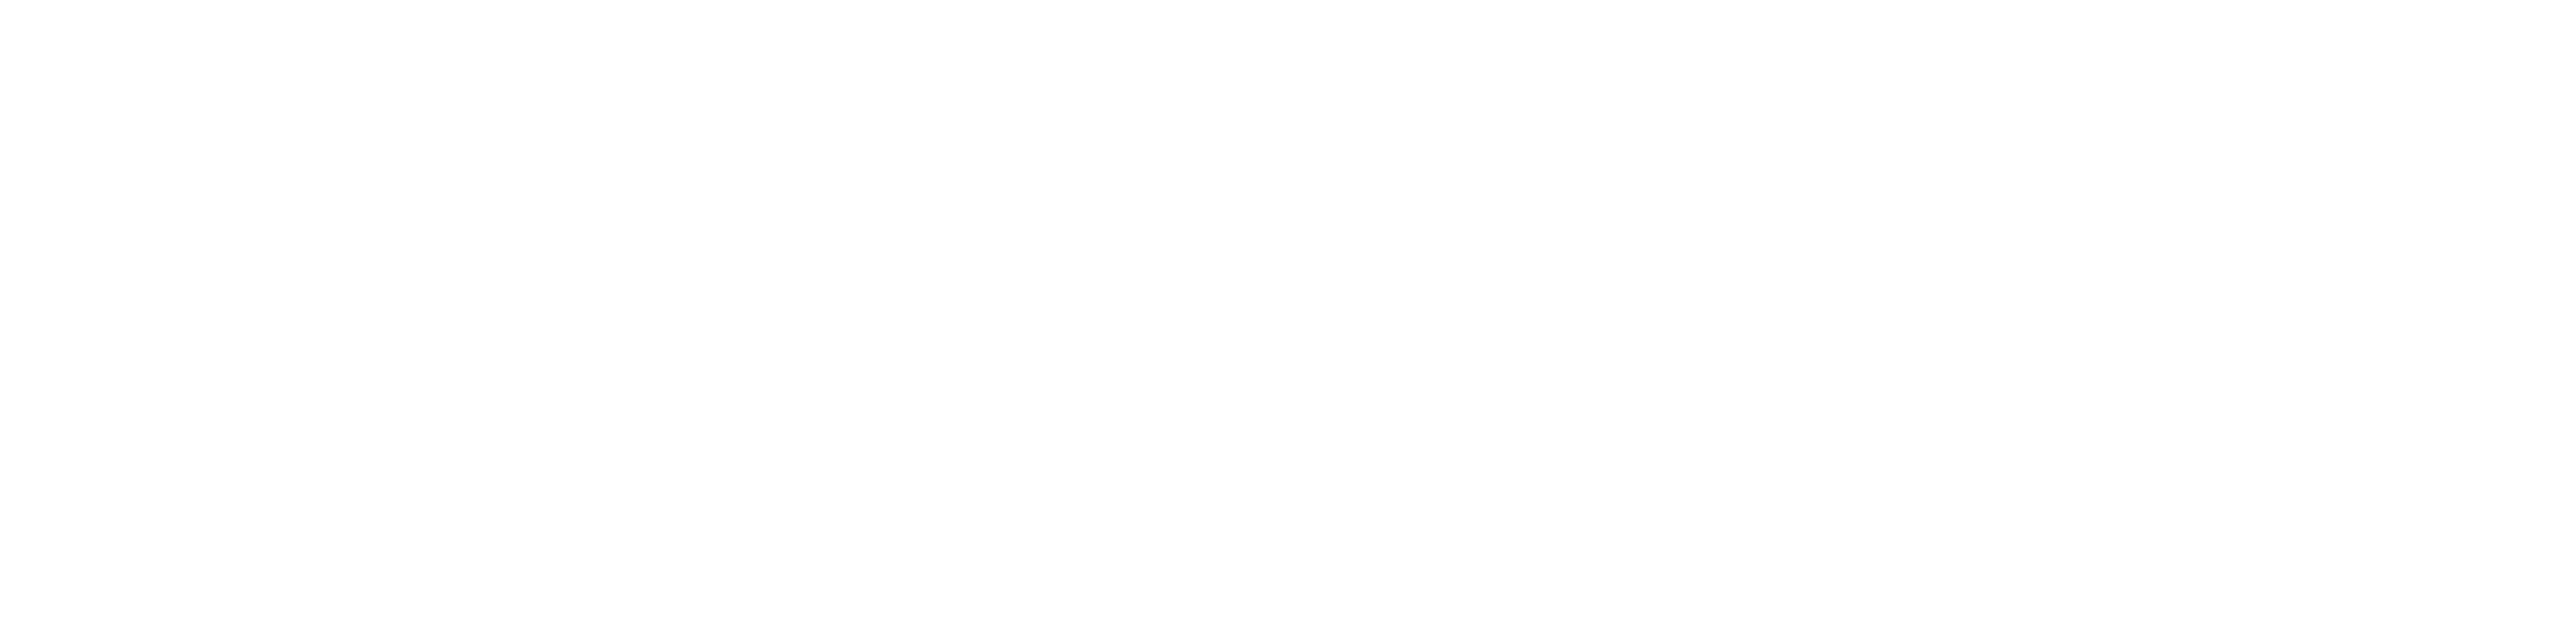

Before release: active_bytes.all.current: 103.24224 MB
After release: active_bytes.all.current: 103.24224 MB


In [17]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(smplshMesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())
visualize2DSilhouetteResults(images, backGroundImages = crops_out, outImgFile=join(outFolderForExperiment, 'Initial.png'))
showCudaMemUsage(device)

In [18]:
image_cur.dtype

torch.float32

In [19]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

optimizer = torch.optim.Adam([trans, pose, betas], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [20]:
# smplshRegressorMatHead = torch.tensor(smplshRegressorMatHead,  dtype=torch.float32, device=device, requires_grad=False)
headKps = torch.tensor( Keypoints.points[OPHeadKeypoints, :],  dtype=torch.float32, device=device, requires_grad=False)

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


2020-07-16 18:10:35,161 logger INFO loss 1.706049, headKpFixingLoss 4.973114, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:10:41,549 logger INFO loss 1.706037, headKpFixingLoss 4.973117, regularizerLoss 0.000013, MemUsed:126.39
2020-07-16 18:10:47,930 logger INFO loss 1.700559, headKpFixingLoss 4.886116, regularizerLoss 0.000013, MemUsed:126.39
2020-07-16 18:10:54,334 logger INFO loss 1.695177, headKpFixingLoss 4.824938, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:11:00,757 logger INFO loss 1.692414, headKpFixingLoss 4.779681, regularizerLoss 0.000013, MemUsed:126.39
2020-07-16 18:11:07,167 logger INFO loss 1.689852, headKpFixingLoss 4.765273, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:11:13,598 logger INFO loss 1.687734, headKpFixingLoss 4.777822, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:11:20,018 logger INFO loss 1.686897, headKpFixingLoss 4.806892, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:11:26,436 logger INFO loss 1.68506

<IPython.core.display.Javascript object>


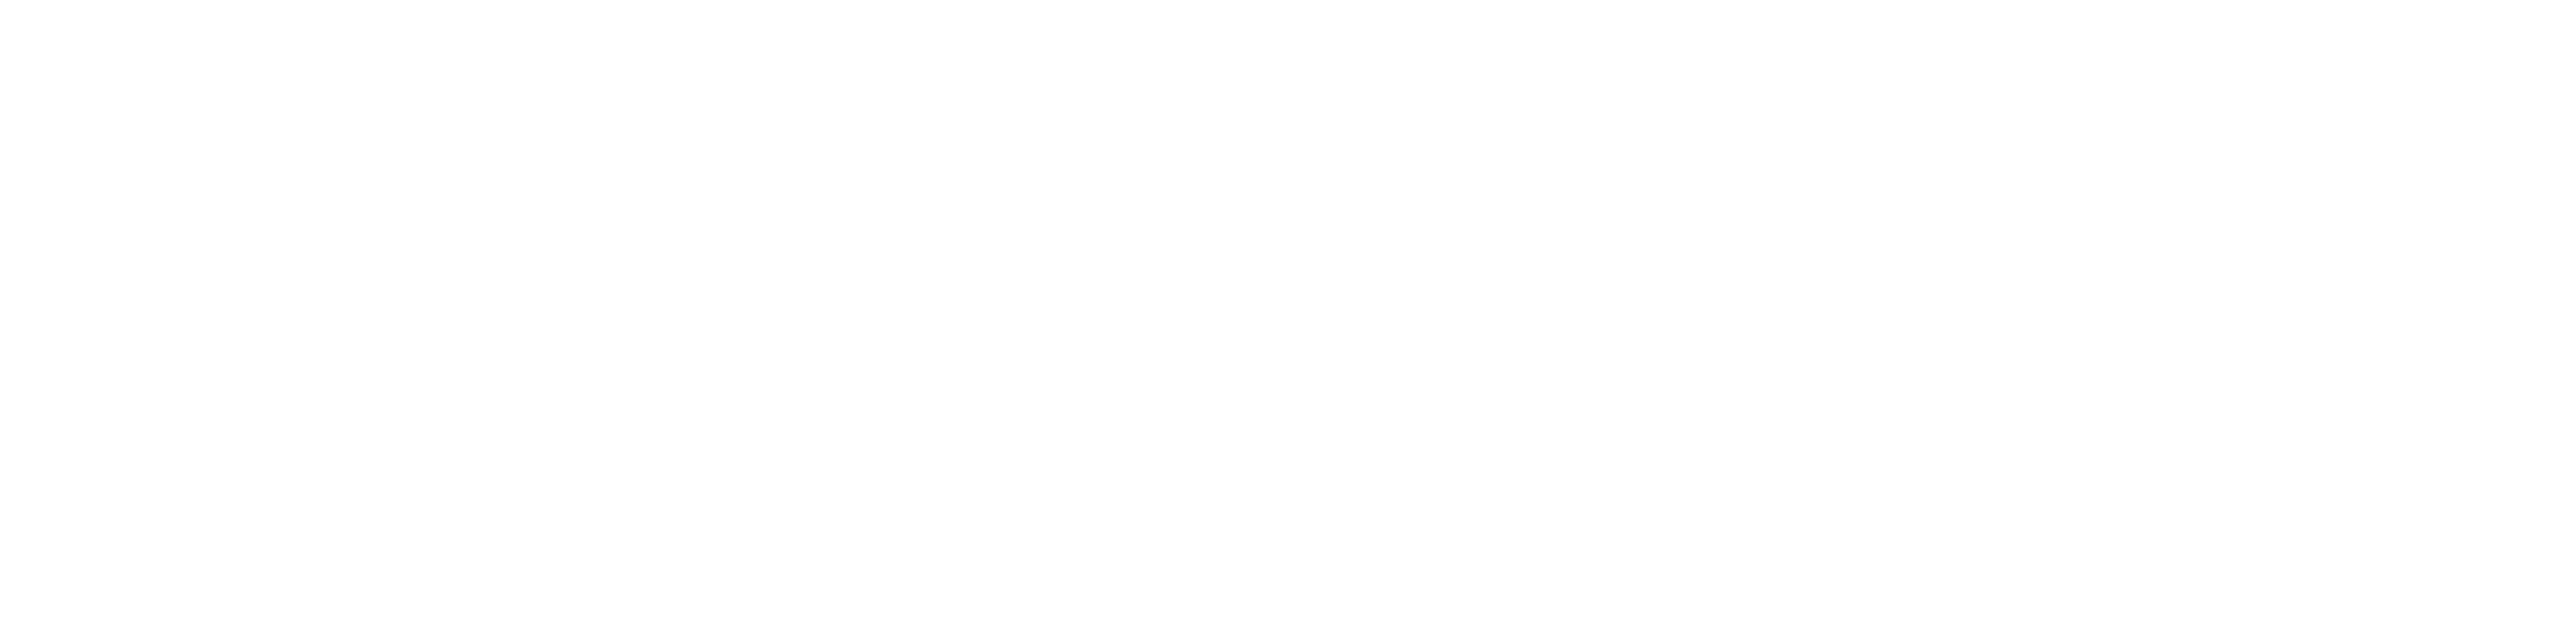

2020-07-16 18:14:07,774 logger INFO loss 1.670156, headKpFixingLoss 5.117631, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:14,189 logger INFO loss 1.669433, headKpFixingLoss 5.115539, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:20,617 logger INFO loss 1.668946, headKpFixingLoss 5.112745, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:27,025 logger INFO loss 1.668780, headKpFixingLoss 5.108409, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:33,414 logger INFO loss 1.668294, headKpFixingLoss 5.107485, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:39,821 logger INFO loss 1.667550, headKpFixingLoss 5.112119, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:46,237 logger INFO loss 1.666947, headKpFixingLoss 5.125020, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:52,655 logger INFO loss 1.666512, headKpFixingLoss 5.144746, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:14:59,075 logger INFO loss 1.66605

<IPython.core.display.Javascript object>


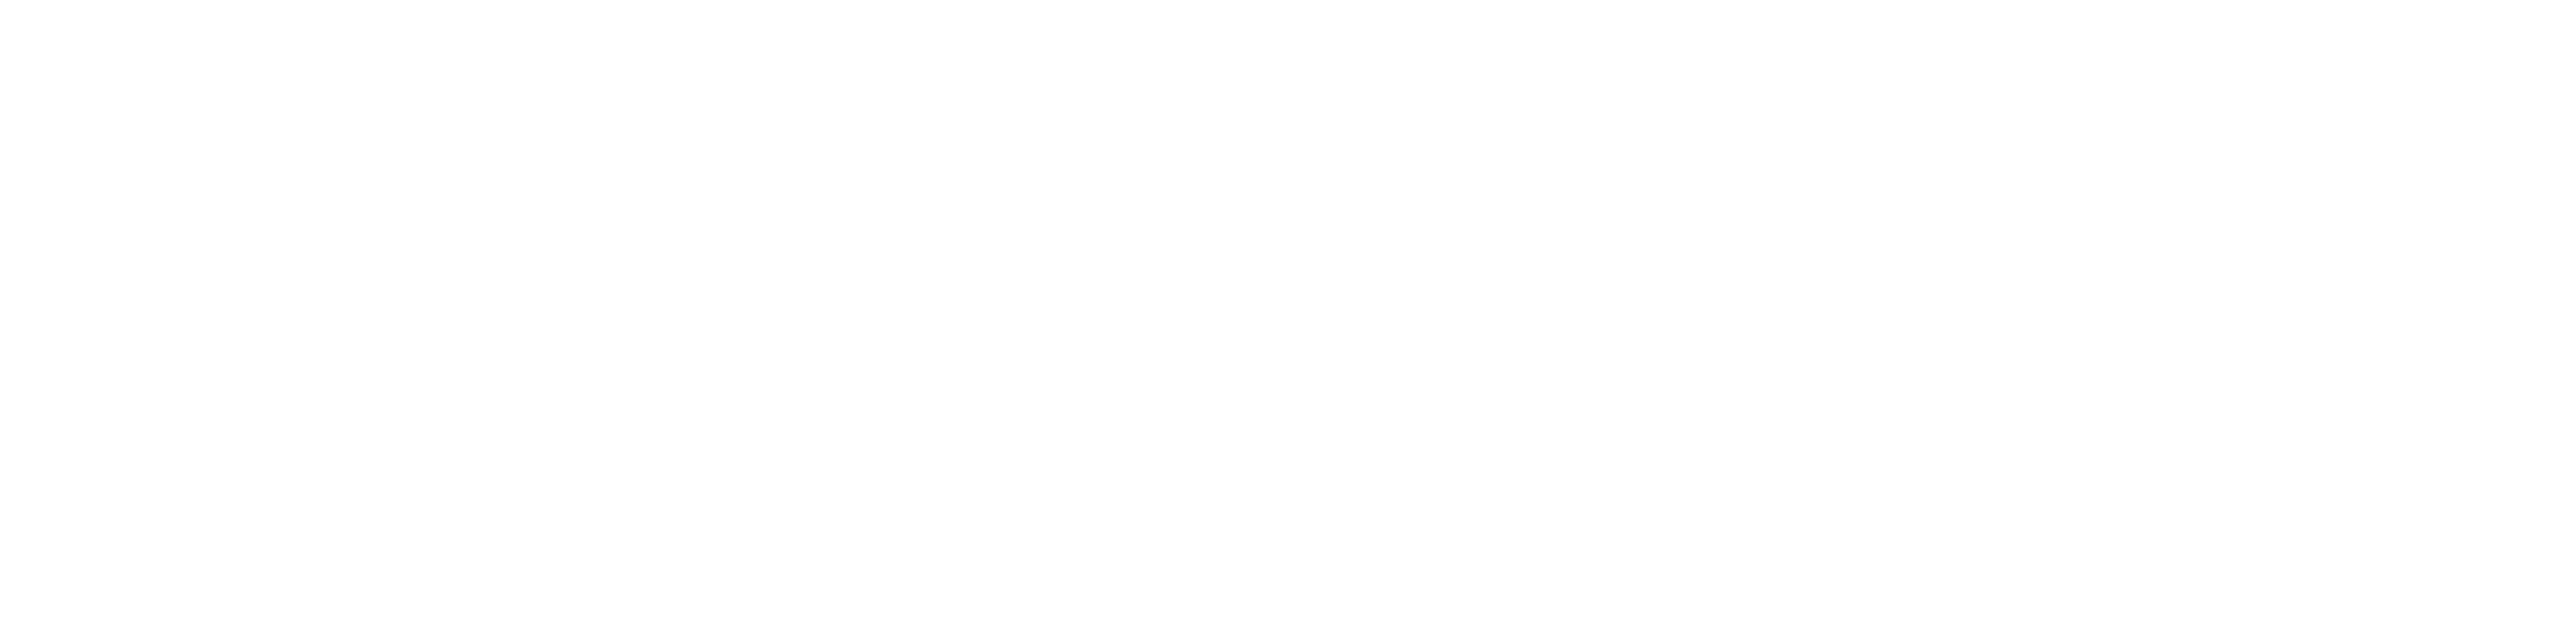

2020-07-16 18:17:38,796 logger INFO loss 1.655391, headKpFixingLoss 5.395509, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:17:45,209 logger INFO loss 1.654933, headKpFixingLoss 5.411996, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:17:51,609 logger INFO loss 1.654112, headKpFixingLoss 5.429409, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:17:58,023 logger INFO loss 1.653335, headKpFixingLoss 5.446461, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:18:04,430 logger INFO loss 1.652766, headKpFixingLoss 5.463589, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:18:10,838 logger INFO loss 1.652435, headKpFixingLoss 5.471614, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:18:17,261 logger INFO loss 1.652099, headKpFixingLoss 5.468681, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:18:23,693 logger INFO loss 1.651827, headKpFixingLoss 5.465925, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:18:30,109 logger INFO loss 1.65139

<IPython.core.display.Javascript object>


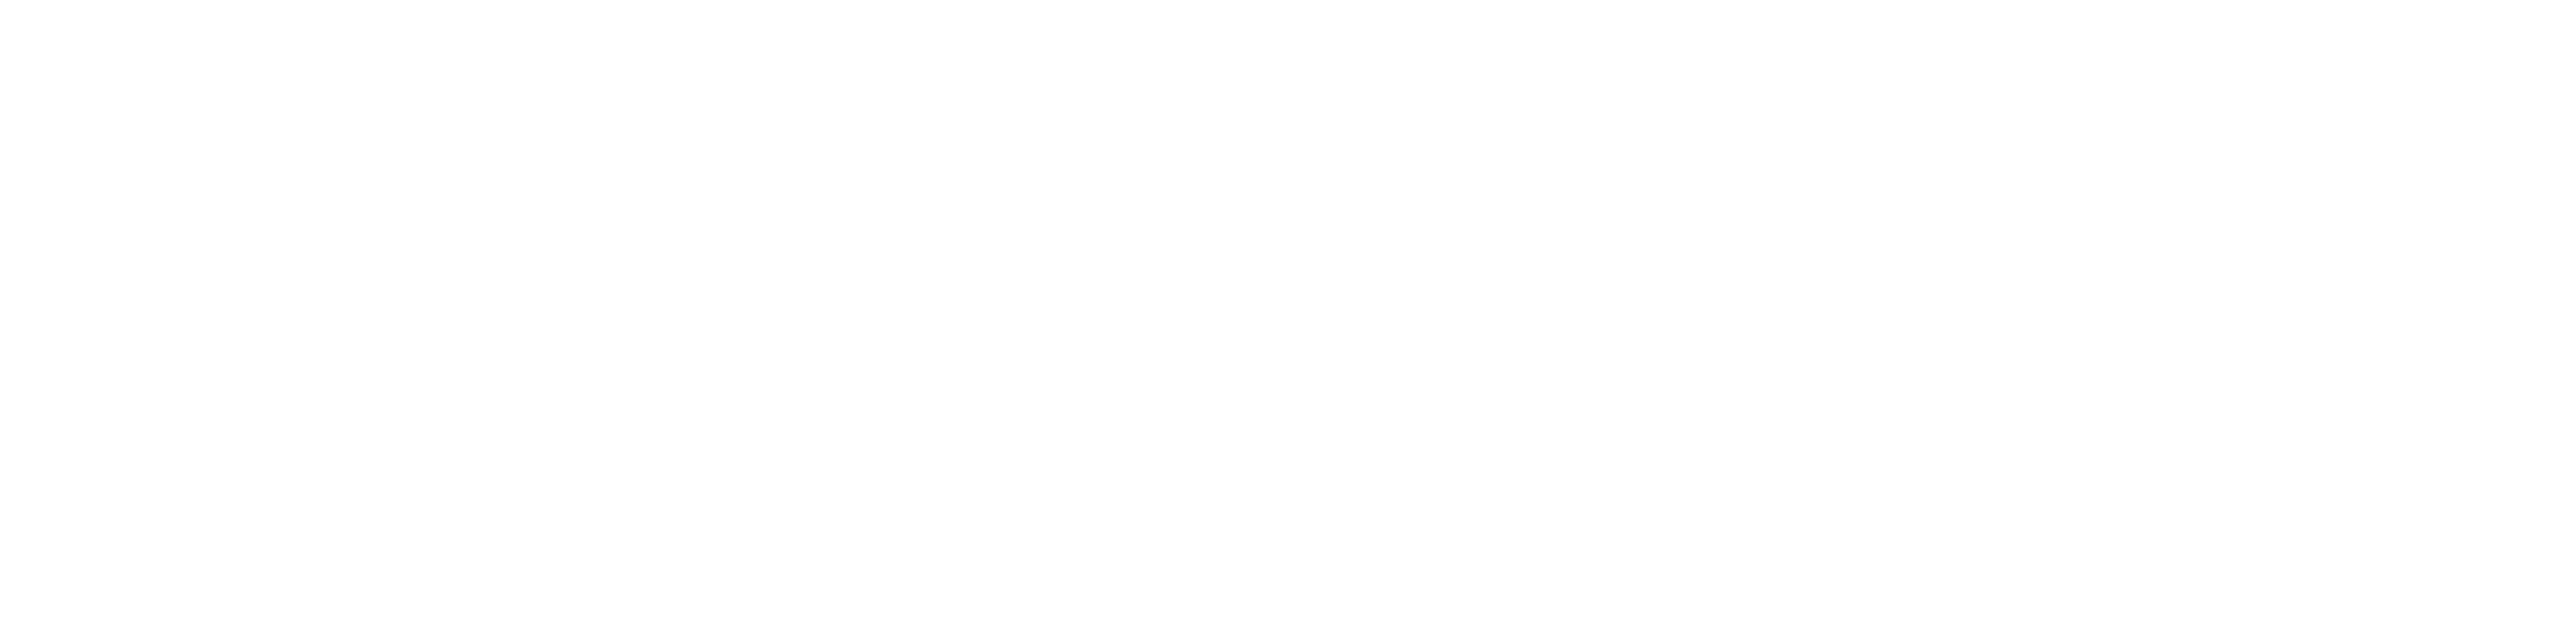

2020-07-16 18:21:10,231 logger INFO loss 1.643274, headKpFixingLoss 5.793464, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:21:16,658 logger INFO loss 1.642914, headKpFixingLoss 5.808600, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:21:23,216 logger INFO loss 1.642677, headKpFixingLoss 5.811535, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:21:29,719 logger INFO loss 1.642506, headKpFixingLoss 5.815660, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:21:36,281 logger INFO loss 1.642174, headKpFixingLoss 5.825285, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:21:42,809 logger INFO loss 1.641865, headKpFixingLoss 5.848123, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:21:49,488 logger INFO loss 1.641289, headKpFixingLoss 5.872608, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:21:56,315 logger INFO loss 1.641117, headKpFixingLoss 5.888051, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:22:04,612 logger INFO loss 1.64075

<IPython.core.display.Javascript object>


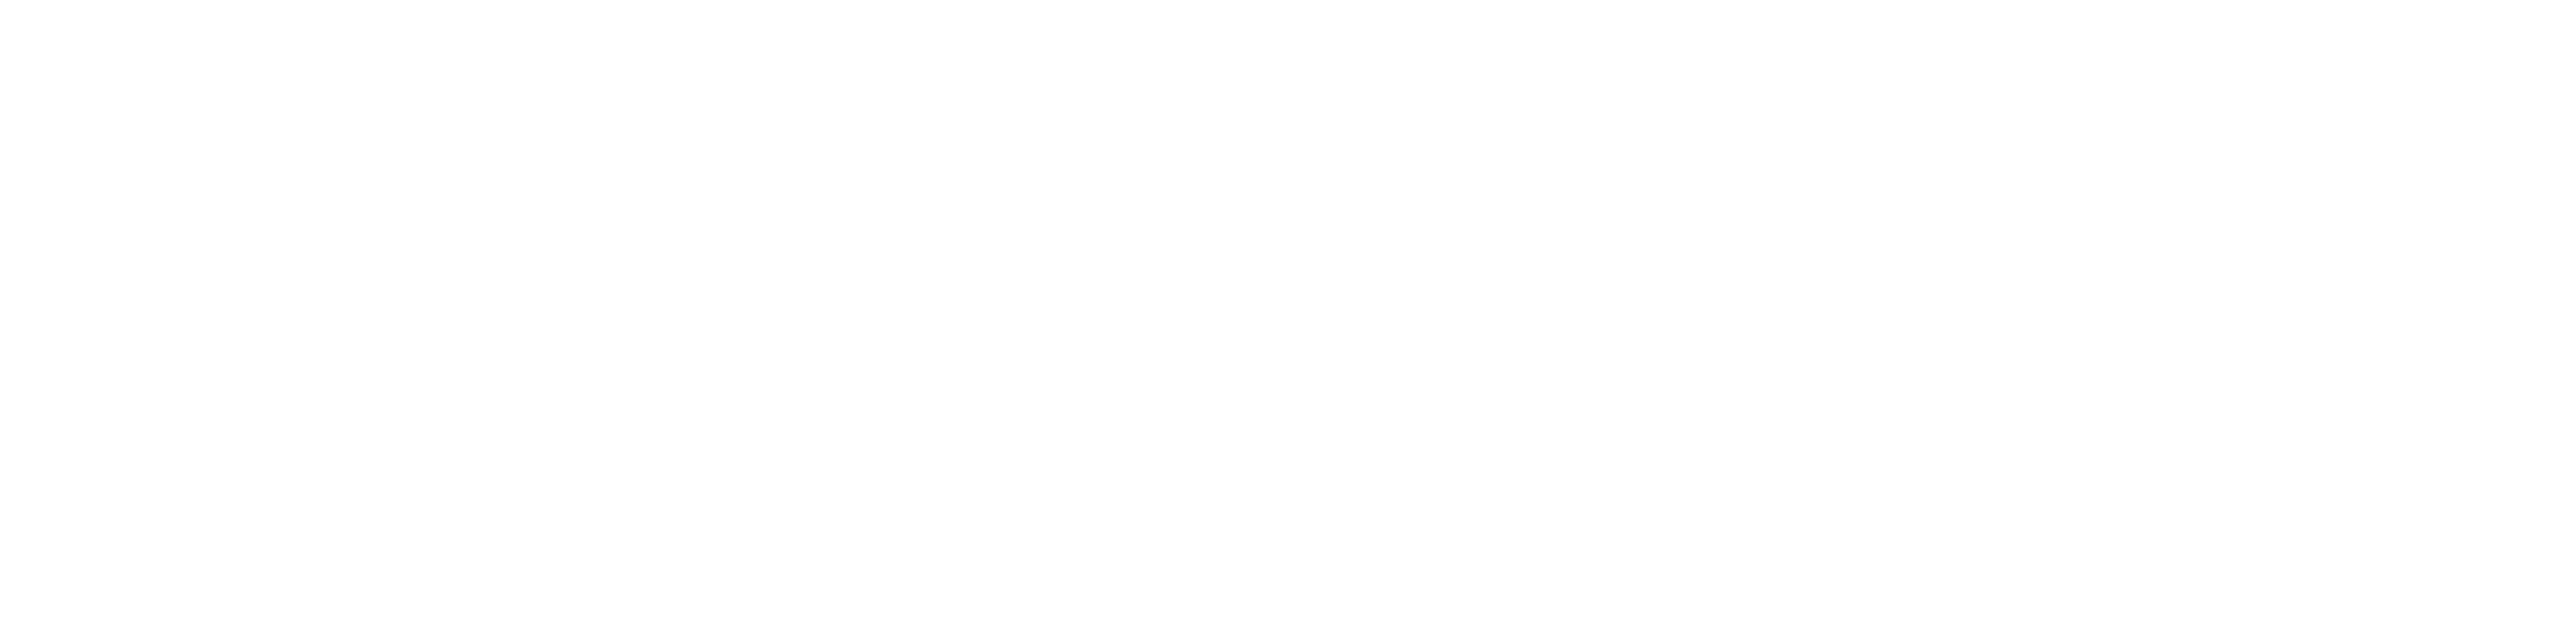

2020-07-16 18:24:56,576 logger INFO loss 1.634395, headKpFixingLoss 6.264564, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:03,040 logger INFO loss 1.633676, headKpFixingLoss 6.299722, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:09,537 logger INFO loss 1.633703, headKpFixingLoss 6.315361, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:16,162 logger INFO loss 1.633632, headKpFixingLoss 6.309276, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:22,790 logger INFO loss 1.633589, headKpFixingLoss 6.305238, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:29,381 logger INFO loss 1.633339, headKpFixingLoss 6.311633, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:36,075 logger INFO loss 1.632987, headKpFixingLoss 6.326680, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:42,818 logger INFO loss 1.632455, headKpFixingLoss 6.331777, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:25:49,677 logger INFO loss 1.63221

<IPython.core.display.Javascript object>


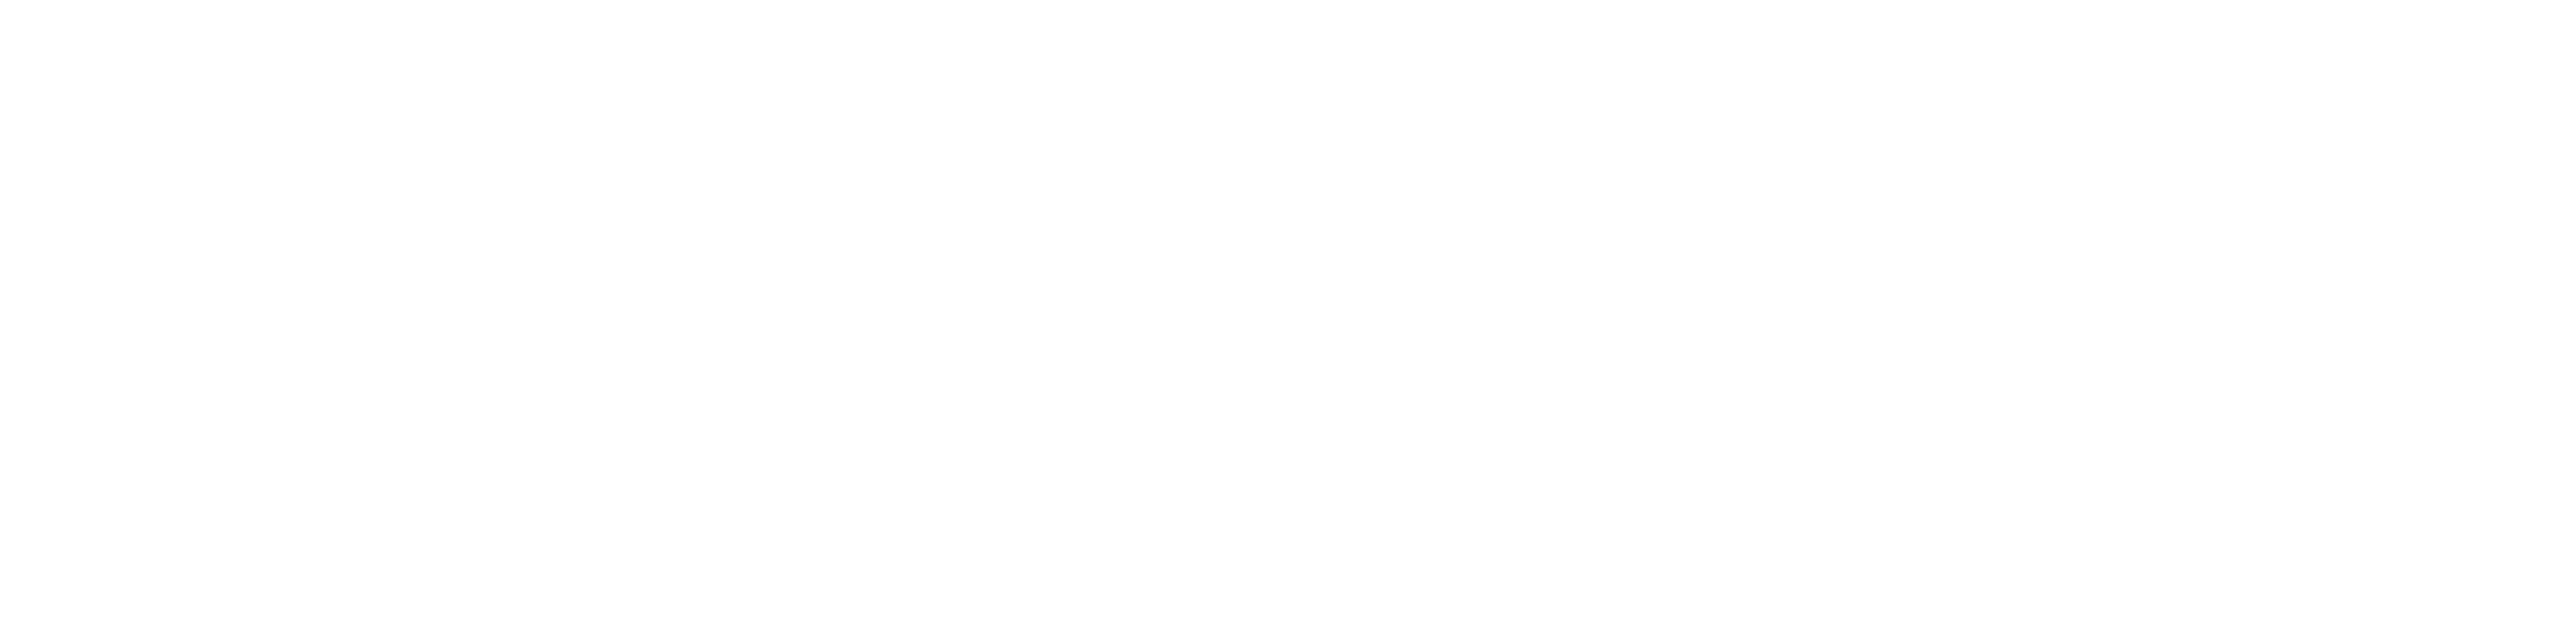

2020-07-16 18:28:31,784 logger INFO loss 1.626348, headKpFixingLoss 6.341090, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:28:38,675 logger INFO loss 1.626258, headKpFixingLoss 6.333928, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:28:45,166 logger INFO loss 1.626086, headKpFixingLoss 6.339655, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:28:51,709 logger INFO loss 1.625991, headKpFixingLoss 6.350801, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:28:58,229 logger INFO loss 1.625871, headKpFixingLoss 6.350909, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:29:04,838 logger INFO loss 1.625500, headKpFixingLoss 6.343050, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:29:11,542 logger INFO loss 1.625391, headKpFixingLoss 6.339060, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:29:18,092 logger INFO loss 1.625123, headKpFixingLoss 6.345266, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:29:24,619 logger INFO loss 1.62476

<IPython.core.display.Javascript object>


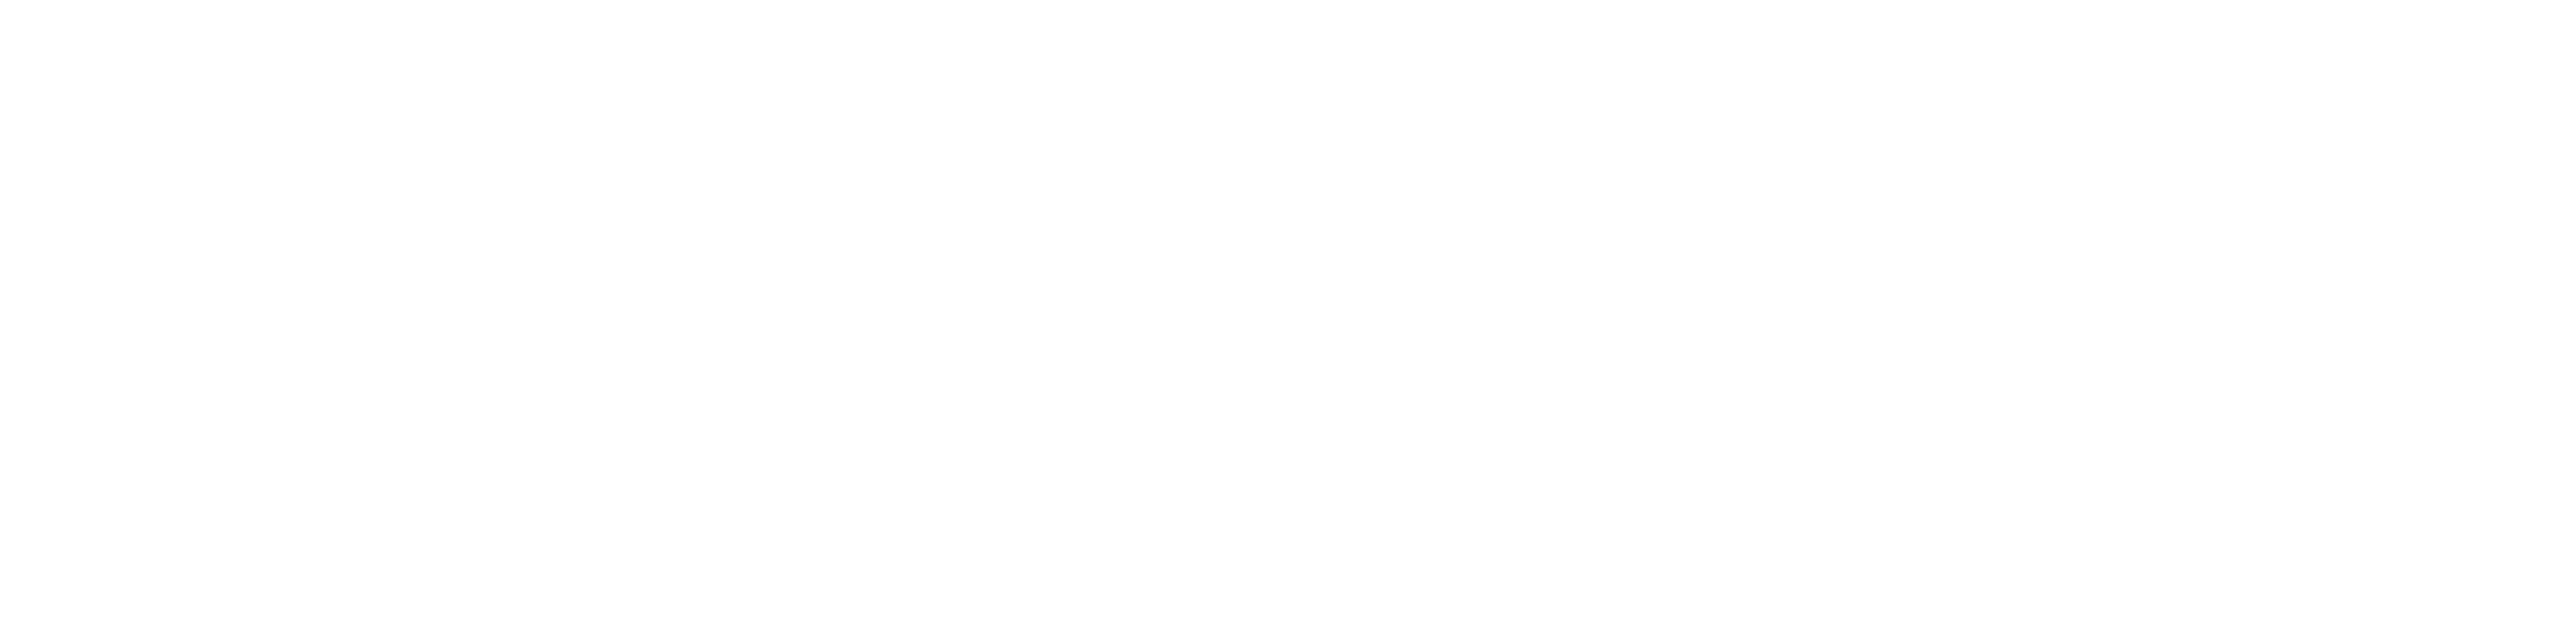

2020-07-16 18:32:06,748 logger INFO loss 1.619674, headKpFixingLoss 6.483616, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:32:13,219 logger INFO loss 1.619262, headKpFixingLoss 6.481712, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:32:19,746 logger INFO loss 1.618724, headKpFixingLoss 6.497323, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:32:28,197 logger INFO loss 1.618519, headKpFixingLoss 6.494187, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:32:34,789 logger INFO loss 1.618318, headKpFixingLoss 6.491760, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:32:41,348 logger INFO loss 1.618005, headKpFixingLoss 6.507807, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:32:47,982 logger INFO loss 1.617658, headKpFixingLoss 6.523542, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:32:54,523 logger INFO loss 1.617305, headKpFixingLoss 6.518813, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:33:01,092 logger INFO loss 1.61724

<IPython.core.display.Javascript object>


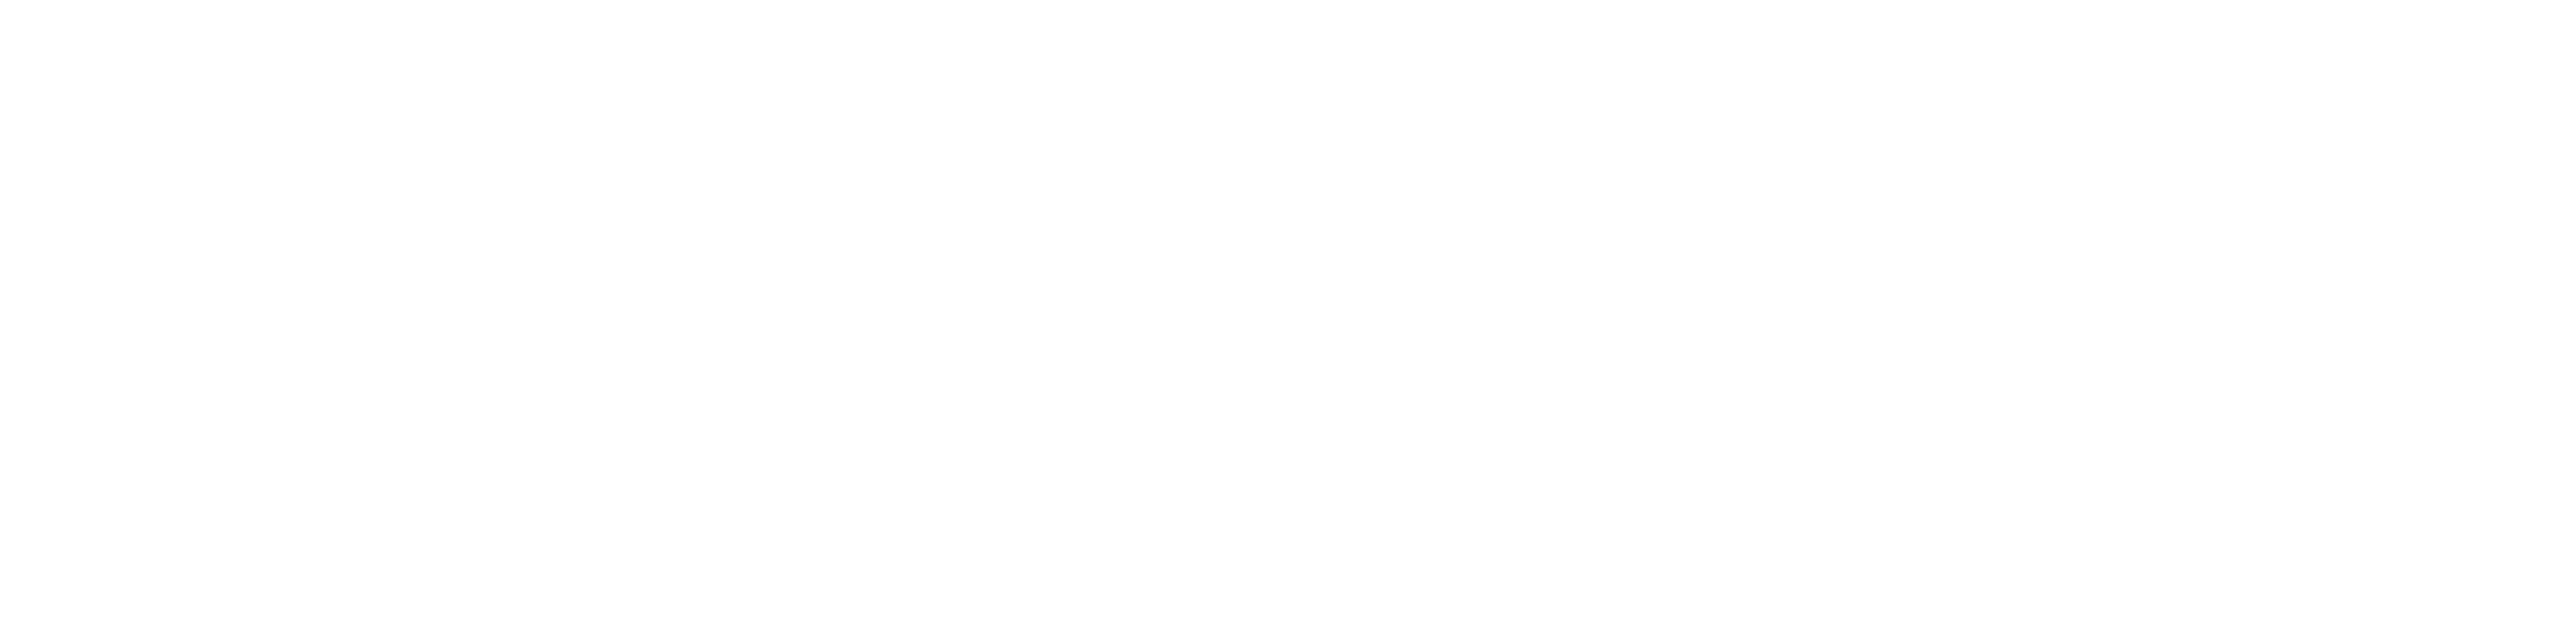

2020-07-16 18:35:47,372 logger INFO loss 1.613436, headKpFixingLoss 6.683332, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:35:53,854 logger INFO loss 1.613180, headKpFixingLoss 6.702966, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:36:00,349 logger INFO loss 1.613205, headKpFixingLoss 6.719073, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:36:06,837 logger INFO loss 1.612939, headKpFixingLoss 6.744039, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:36:13,354 logger INFO loss 1.612952, headKpFixingLoss 6.763257, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:36:20,451 logger INFO loss 1.612639, headKpFixingLoss 6.788545, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:36:27,232 logger INFO loss 1.612246, headKpFixingLoss 6.825215, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:36:34,130 logger INFO loss 1.611936, headKpFixingLoss 6.846821, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:36:40,833 logger INFO loss 1.61191

<IPython.core.display.Javascript object>


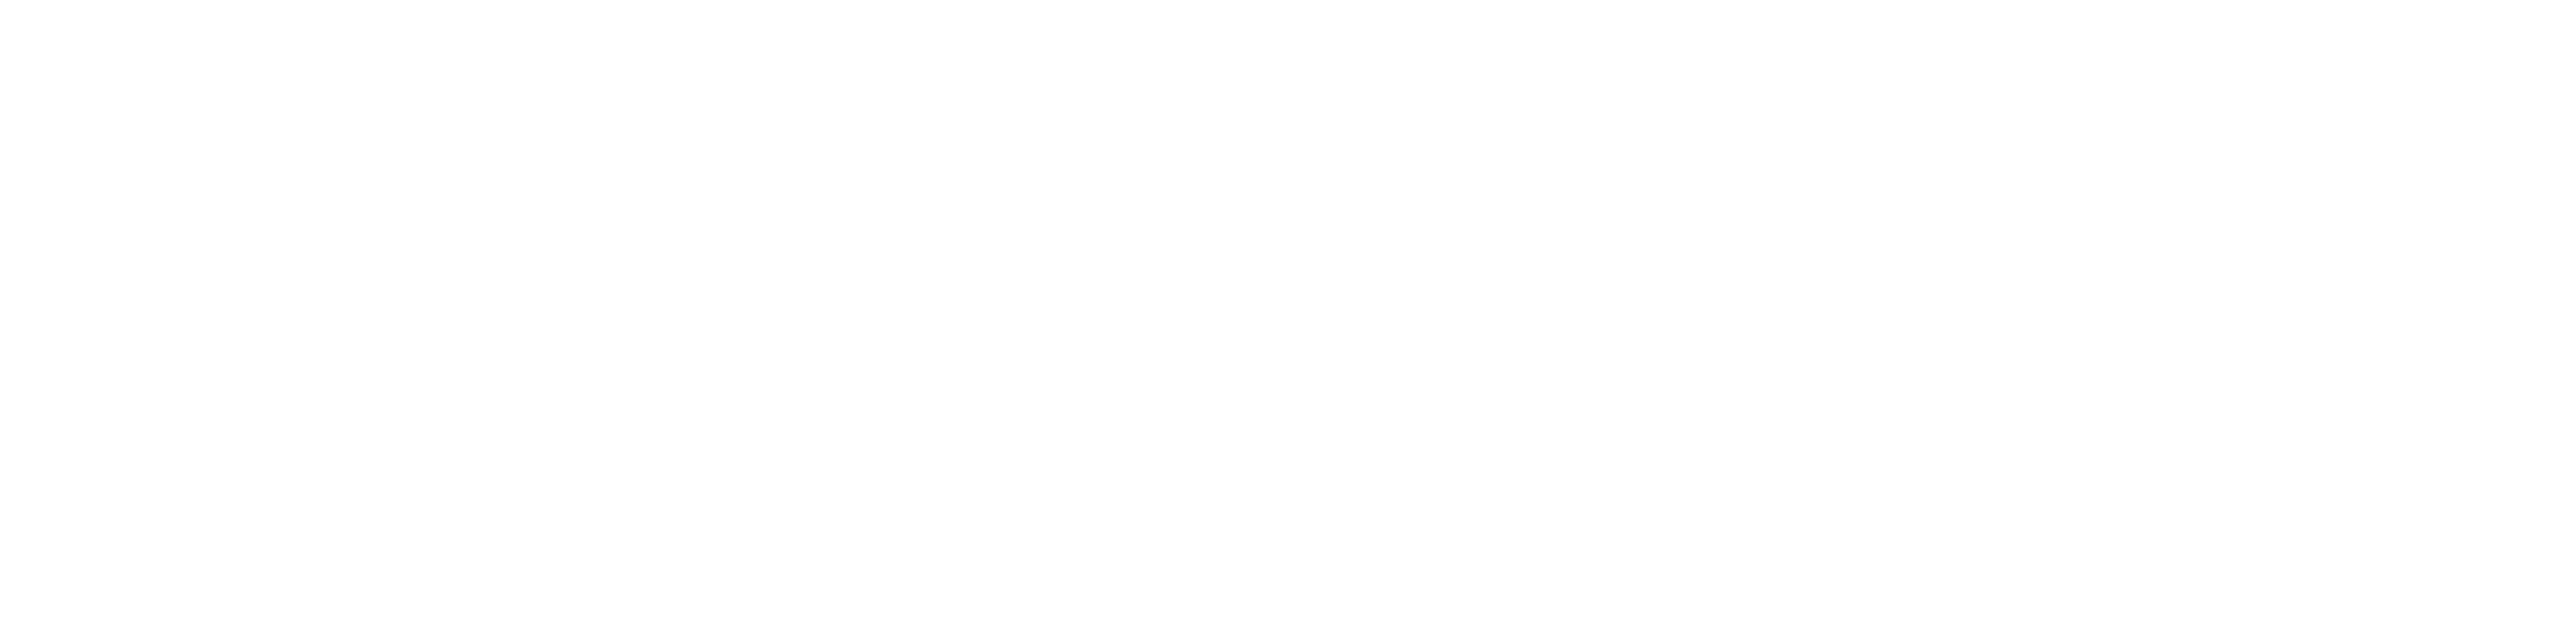

2020-07-16 18:39:23,011 logger INFO loss 1.607266, headKpFixingLoss 7.162451, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:39:29,465 logger INFO loss 1.607407, headKpFixingLoss 7.162898, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:39:35,931 logger INFO loss 1.607242, headKpFixingLoss 7.193436, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:39:42,416 logger INFO loss 1.607130, headKpFixingLoss 7.209373, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:39:48,912 logger INFO loss 1.607144, headKpFixingLoss 7.207686, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:39:55,409 logger INFO loss 1.606973, headKpFixingLoss 7.230040, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:40:01,965 logger INFO loss 1.606769, headKpFixingLoss 7.236825, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:40:08,503 logger INFO loss 1.606697, headKpFixingLoss 7.231758, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:40:15,089 logger INFO loss 1.60599

<IPython.core.display.Javascript object>


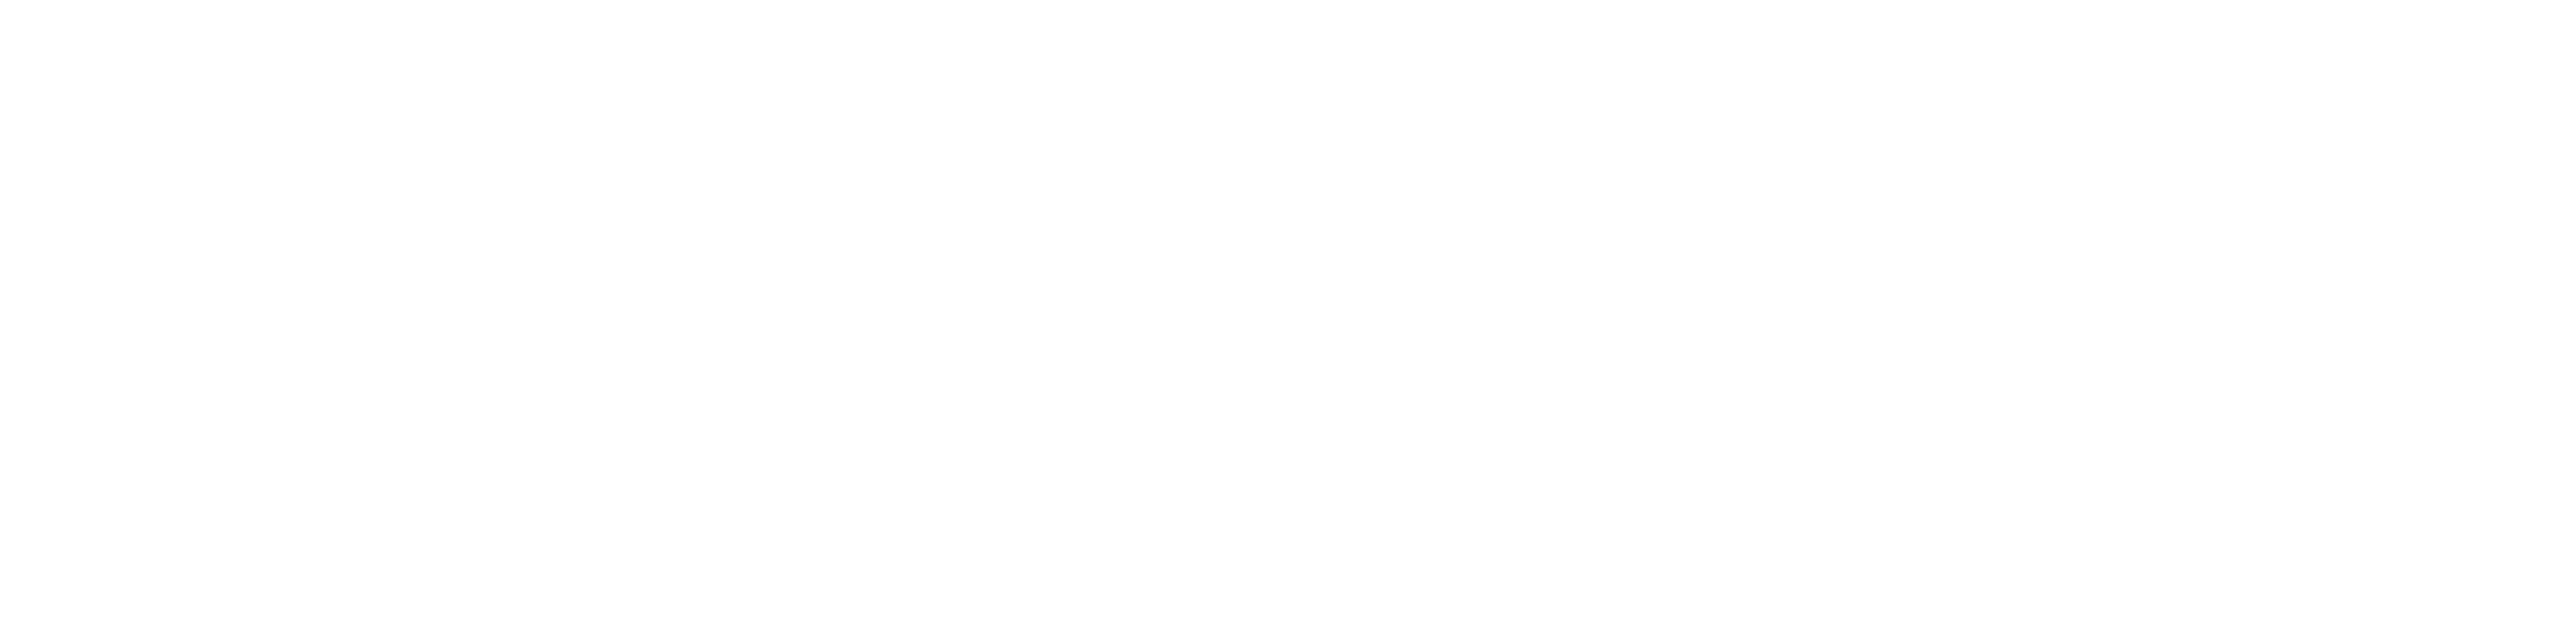

2020-07-16 18:42:57,569 logger INFO loss 1.602572, headKpFixingLoss 7.565624, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:04,164 logger INFO loss 1.602287, headKpFixingLoss 7.578277, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:10,734 logger INFO loss 1.601942, headKpFixingLoss 7.595684, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:17,361 logger INFO loss 1.601373, headKpFixingLoss 7.623063, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:24,088 logger INFO loss 1.601385, headKpFixingLoss 7.624475, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:30,683 logger INFO loss 1.601135, headKpFixingLoss 7.620902, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:37,348 logger INFO loss 1.600993, headKpFixingLoss 7.631939, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:43,977 logger INFO loss 1.600675, headKpFixingLoss 7.644750, regularizerLoss 0.000013, MemUsed:126.37
2020-07-16 18:43:50,529 logger INFO loss 1.60042

<IPython.core.display.Javascript object>


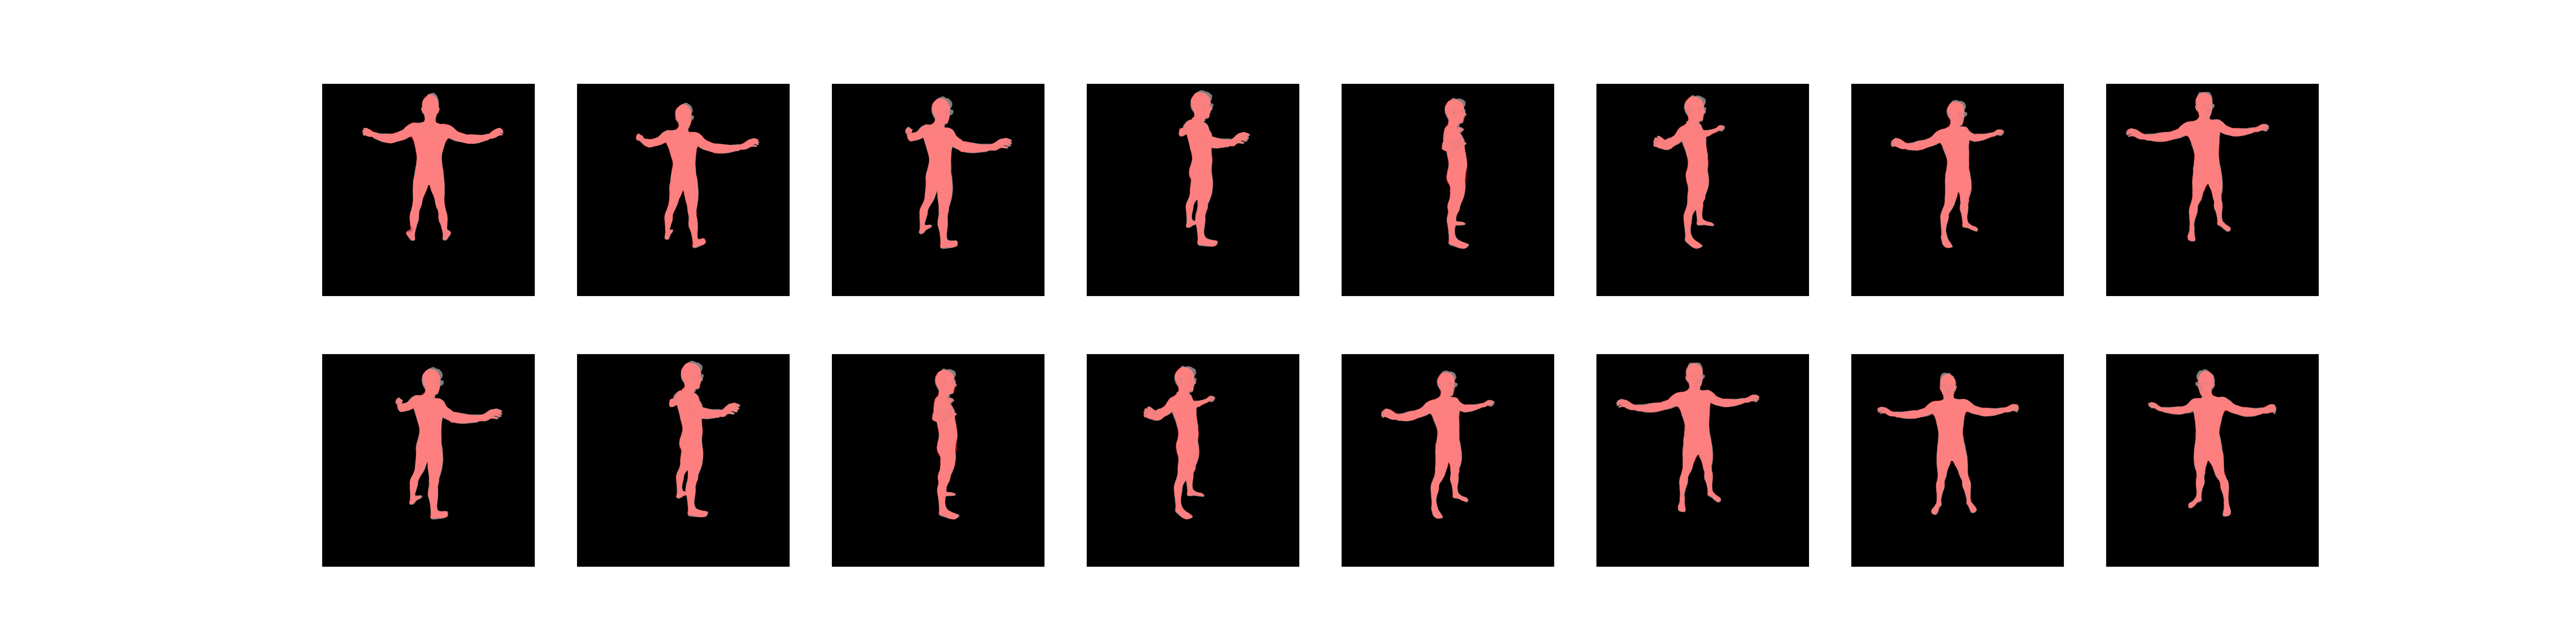

In [21]:
cfg.plotStep = 30
cfg.numIterations = 300
loop = tqdm_notebook(range(cfg.numIterations))

for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        refImg = torch.tensor(crops_out[iCam][..., 0], dtype=torch.float32, device=device, requires_grad=False)
        verts = smplsh(betas, pose, trans).type(torch.float32) * 1000
        smplshMesh = Meshes([verts], [smplsh.faces.to(device)])
        
        images = renderSynth.renderer(smplshMesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[..., 3], p=1) / torch.norm(refImg + images[..., 3] - refImg * images[..., 3], p=1)
        
        loss.backward()
        lossVal += loss.item()
        #showCudaMemUsage(device)
    
#     mesh = Meshes(
#                 verts=[modifiedVerts],   
#                 faces=[faces_idx], 
# #                 textures=textures.to(device)
#             )
#     loss = cfg.normalSmootherW * mesh_normal_consistency(mesh)
    
# #     print("Laplacian on normal shift",  cfg.lpSmootherW * normalShift.transpose(0,1) @ LNP @ normalShift)
    
#     # Laplacian on shift in normal direction
#     loss = loss + cfg.lpSmootherW * normalShift.transpose(0,1) @ LNP @ normalShift
    
#     loss.backward()
#     lossVal += loss.item()
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # joint regularizer
    loss = cfg.jointRegularizerWeight * torch.sum((pose**2))
    loss.backward()
    regularizerLoss = loss.item()
    # recordData
    
    verts, jointsDeformed = smplsh(betas, pose, trans, returnDeformedJoints=True)
    verts = verts.type(torch.float32) * 1000
    jointsDeformed = jointsDeformed.type(torch.float32) * 1000
    #     headJoints = smplshRegressorMatHead @ verts
    jointConverter = Utility.VertexToOpJointsConverter()
    smplshOpJoints = jointConverter(verts[None,...], jointsDeformed[None,...])
    headJoints = torch.index_select(smplshOpJoints, 1, torch.tensor(OPHeadKeypoints, dtype=torch.long, device=device))[0,...]

    loss = cfg.kpFixingWeight * torch.sum((headJoints - headKps)**2)
    loss.backward()
    headKpFixingLoss = loss.item()
                     
    losses.append(lossVal)
    
    if i:
        optimizer.step()
        
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    torch.cuda.empty_cache()
    
    infoStr = 'loss %.6f, headKpFixingLoss %.6f, regularizerLoss %.6f, MemUsed:%.2f' \
        % (lossVal, headKpFixingLoss, regularizerLoss, memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if (i+1) % cfg.plotStep == 0:
        showCudaMemUsage(device)
        verts = smplsh(betas, pose, trans).type(torch.float32) * 1000
        smplshMesh = Meshes([verts], [smplsh.faces.to(device)])

        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        renderedImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(smplshMesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
#                 imgDiff = np.abs(image_cur.cpu().detach().numpy() - crops_out[iCam][..., 0])
                renderedImages.append(image_cur.cpu().detach().numpy())
            torch.cuda.empty_cache()

#             showCudaMemUsage(device)
#         visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
        visualize2DSilhouetteResults(renderedImages, backGroundImages = crops_out, outImgFile=outImgFile, sizeInInches=5)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.ply'), verts.cpu().detach().numpy(), smplshExampleMesh)


In [22]:
transVal = trans.cpu().detach().numpy()
poseVal = pose.cpu().detach().numpy()
betaVal = betas.cpu().detach().numpy()

outParamFile = join(outFolderForExperiment,  'FittingParam.npz')
np.savez(outParamFile, trans = transVal, pose=poseVal, beta=betaVal)